In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib 

font = {'size': 18}

matplotlib.rc('font', **font) 

In [4]:
from recommender_systems.extra_functions import work_with_matrices, work_with_ratings
from recommender_systems.models.implicit_models import *
from recommender_systems.models.latent_factor_models import *
from recommender_systems.metrics import *
from recommender_systems.models.memory_based_models import *

In [6]:
data = work_with_matrices.read_matrix_from_file(f'../data_train/matrices/random_matrix_50_100.npz')

In [7]:
x_train = work_with_matrices.get_train_matrix(data, 0.4)

In [8]:
PARAMS_KNN_50 = np.arange(1, 50, 2)
PARAMS_DIMENSION_50 = np.arange(1, 50, 2)
PARAMS_LEARNING_RATE = np.arange(0, 0.11, 0.01)
PARAMS_USER_REG = PARAMS_ITEM_REG = PARAMS_INFLUENCE_REG = np.arange(0, 1, 0.1)
PARAMS_BARRIER_VALUE = np.arange(0.1, 1, 0.1)

# Эксперименты с поведеним различных метрик в процессе обучения

In [9]:
DEBUG_NAMES = ['mse', 'rmse', 'mae']

In [10]:
def get_debug_values(model, epochs, debug_name):
    model.fit(data.astype(float), epochs=epochs, debug_name=debug_name)
    return model.debug_information.get()

In [11]:
def create_plot_1(ax, debug_values, model_name, debug_name):
    model_name = model_name[:model_name.find('[')]
    ax.plot(range(len(debug_values)), debug_values)
    ax.set_title(model_name)
    ax.set_xlabel('epochs')
    ax.set_ylabel(debug_name)

In [12]:
def generate_experiment(data_name, model, epochs, debug_name):
    data = work_with_matrices.read_matrix_from_file(f'{PACKAGE_FOR_TRAIN_DATA}/{data_name}.npz')
    x_train = work_with_matrices.get_train_matrix(data, 0.4)
    debug_values = get_debug_values(model, x_train, epochs, debug_name)
    create_plot(debug_values, data_name, str(model), debug_name)

In [13]:
experiments = list()

for debug_name in DEBUG_NAMES:
    experiments.extend([
        (StochasticLatentFactorModel(40, 0.0001), debug_name),
        (AlternatingLeastSquaresModel(40), debug_name),
        (HierarchicalAlternatingLeastSquaresModel(40), debug_name),
        (ImplicitStochasticLatentFactorModel(40, 0.0001), debug_name),
        (ImplicitHierarchicalAlternatingLeastSquaresModel(40), debug_name),
    ])

In [ ]:
debug_values = [
    get_debug_values(model, 30, debug_name)
    for model, debug_name in experiments
]

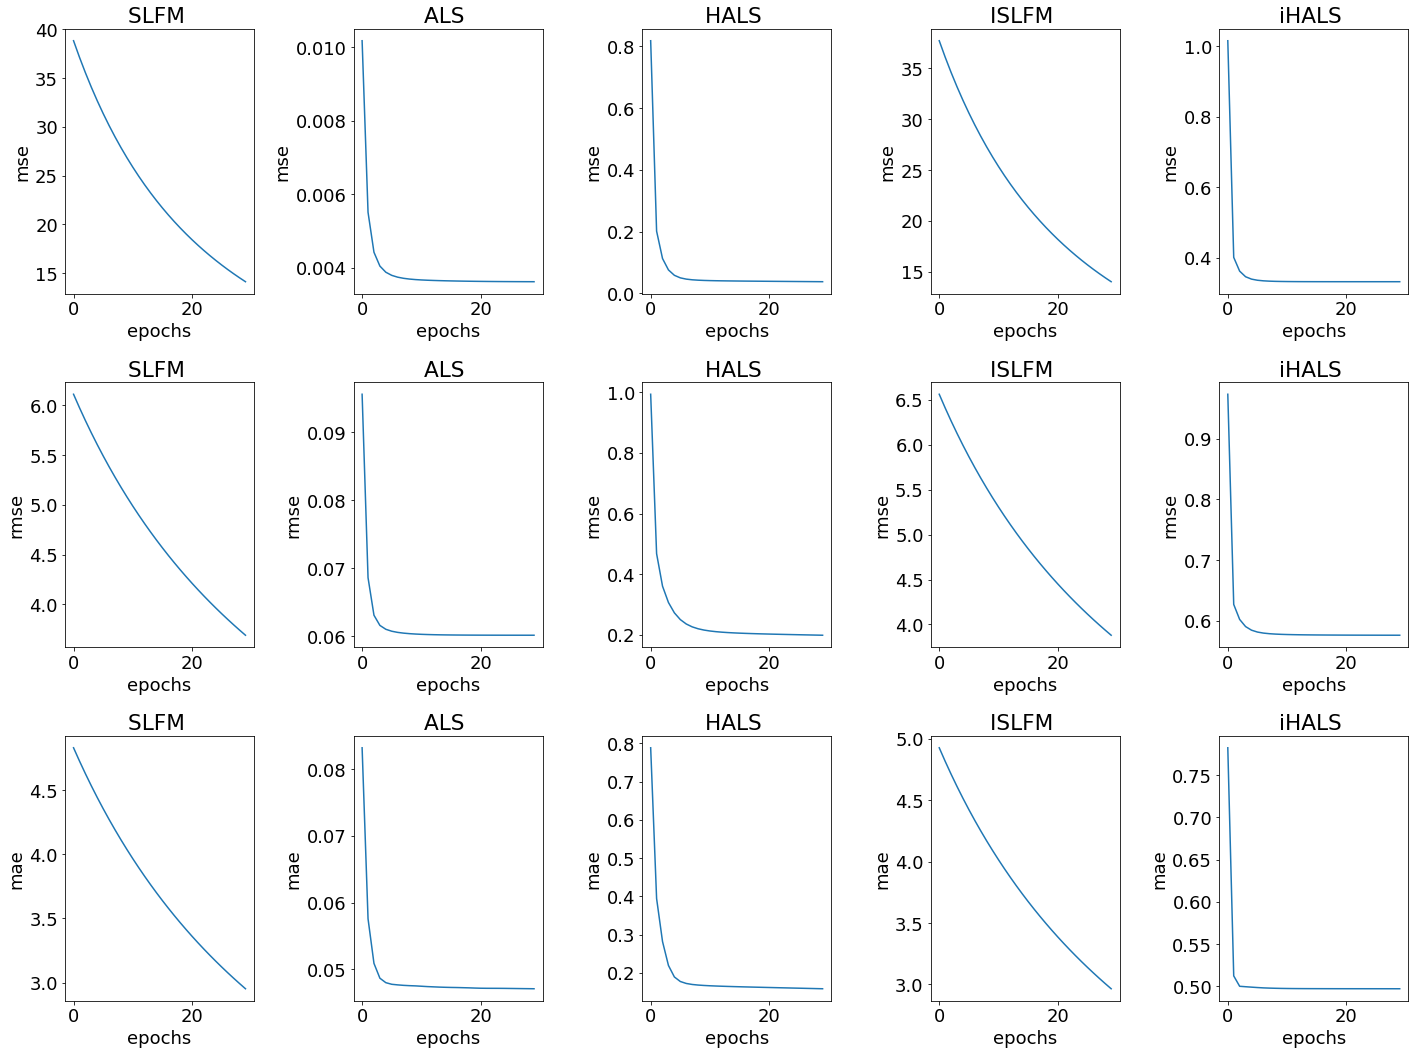

In [15]:
fig, axes = plt.subplots(3, 5, figsize=(20, 15))

for index, values in enumerate(zip(debug_values, experiments)):
    create_plot_1(axes[index // 5, index % 5], values[0], str(values[1][0]), values[1][1])

fig.tight_layout()

# Эксперименты с предсказанием топ-k рекомендаций

In [16]:
def get_metrics_1(model_class, name_range_parameter, range_parameters, parameters, train_parameters):

    items_count = data.shape[1] // 5
    users_count = data.shape[0]

    result_metrics = []

    for parameter in range_parameters:
        parameters.update({name_range_parameter: parameter})
        model = model_class(**parameters).fit(x_train.astype(float), **train_parameters)

        y_pred = [
            model.predict(user_index)[:items_count] for user_index in np.arange(users_count)
        ]

        y_true = [
            data.getrow(user_index).toarray()[0].argsort()[::-1][:items_count]
            for user_index in np.arange(users_count)
        ]

        result_metrics.append(precision_k(y_true, y_pred))

    return result_metrics

In [17]:
def create_plot_2(ax, result_metrics, range_parameters, model_name, parameter_name):
    ax.plot(range_parameters, result_metrics)
    ax.set_title(model_name)
    ax.set_xlabel(parameter_name)
    ax.set_ylabel('precision')

In [18]:
result_metrics = get_metrics_1(
    UserBasedModel, 'k_nearest_neighbours', PARAMS_KNN_50, {}, {}
)

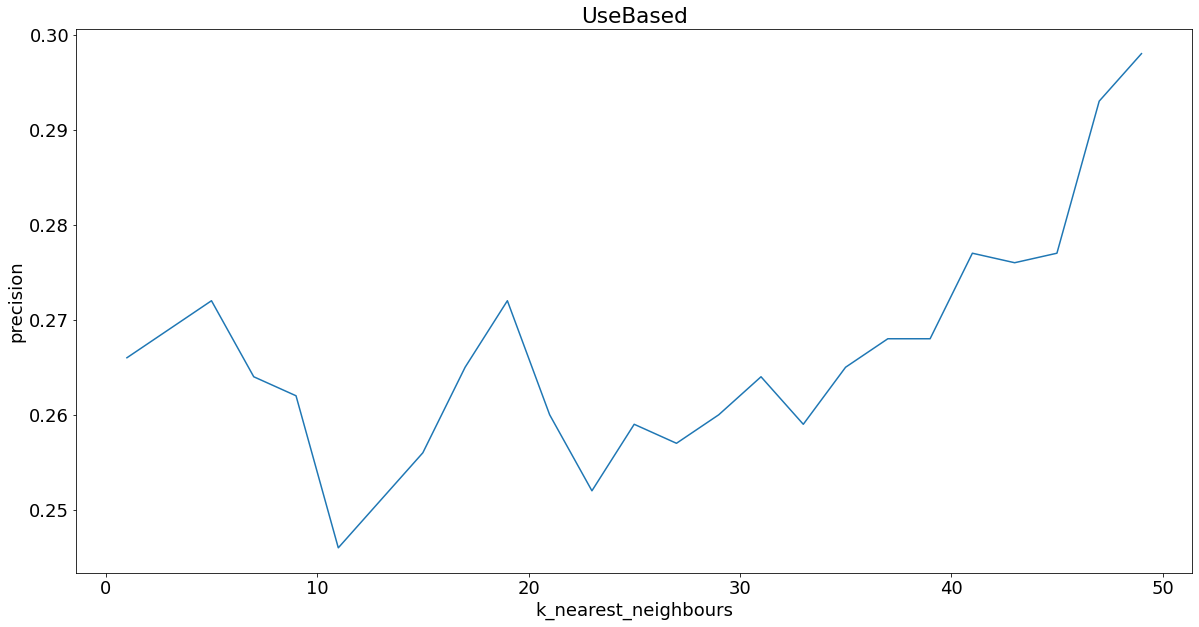

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
create_plot_2(ax, result_metrics, PARAMS_KNN_50, 'UseBased', 'k_nearest_neighbours')

In [20]:
result_metrics_1 = get_metrics_1(
    ItemBasedModel, 'k_nearest_neighbours', PARAMS_KNN_50, {'barrier_type': 'mean'}, {}
)
result_metrics_2 = get_metrics_1(
    ItemBasedModel, 'k_nearest_neighbours', PARAMS_KNN_50, {'barrier_type': 'median'}, {}
)

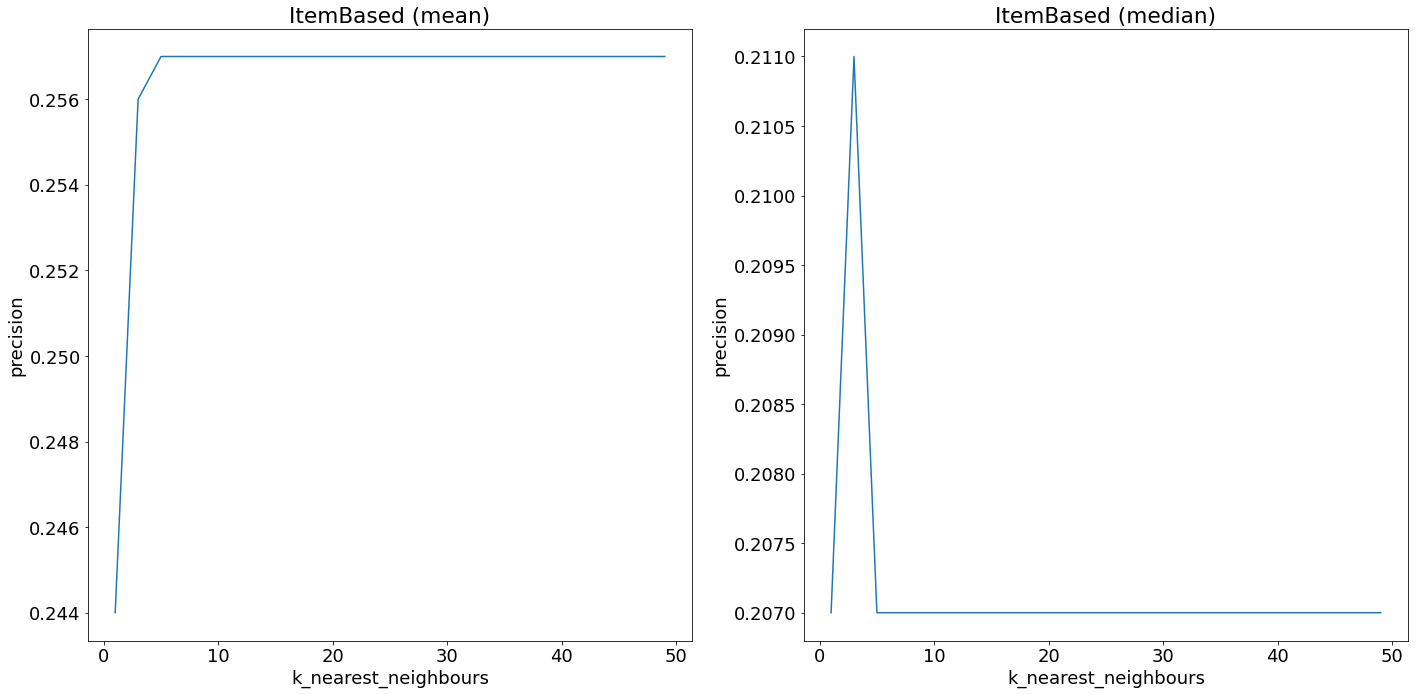

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

create_plot_2(axes[0], result_metrics_1, PARAMS_KNN_50, 'ItemBased (mean)', 'k_nearest_neighbours')
create_plot_2(axes[1], result_metrics_2, PARAMS_KNN_50, 'ItemBased (median)', 'k_nearest_neighbours')

fig.tight_layout()

In [ ]:
result_metrics_1 = get_metrics_1(
    StochasticLatentFactorModel, 'dimension', PARAMS_DIMENSION_50, 
    {'learning_rate': 0.0001}, {'epochs': 30}
)
result_metrics_2 = get_metrics_1(
    StochasticLatentFactorModel, 'learning_rate', PARAMS_LEARNING_RATE, 
    {'dimension': 30}, {'epochs': 30}
)
result_metrics_3 = get_metrics_1(
    StochasticLatentFactorModel, 'user_regularization', PARAMS_USER_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30}
)
result_metrics_4 = get_metrics_1(
    StochasticLatentFactorModel, 'item_regularization', PARAMS_ITEM_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30} 
)

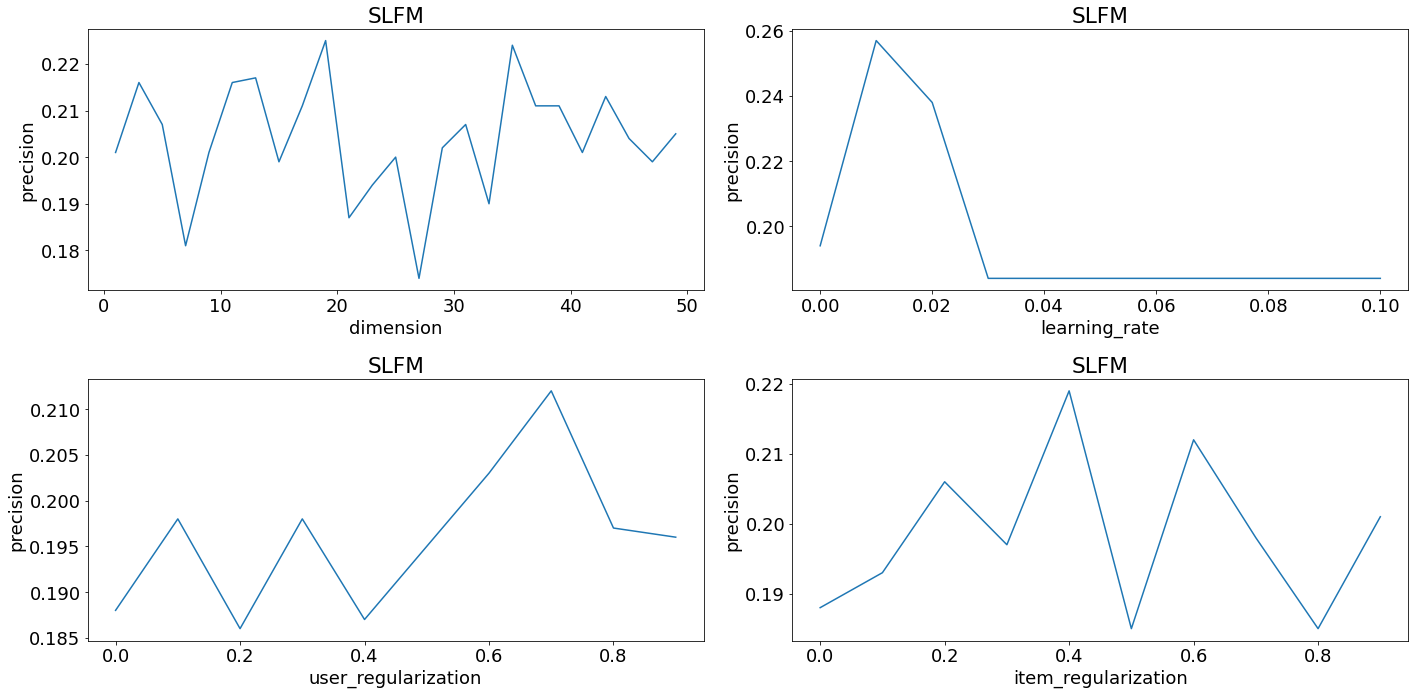

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

create_plot_2(axes[0, 0], result_metrics_1, PARAMS_DIMENSION_50, 'SLFM', 'dimension')
create_plot_2(axes[0, 1], result_metrics_2, PARAMS_LEARNING_RATE, 'SLFM', 'learning_rate')
create_plot_2(axes[1, 0], result_metrics_3, PARAMS_USER_REG, 'SLFM', 'user_regularization')
create_plot_2(axes[1, 1], result_metrics_4, PARAMS_ITEM_REG, 'SLFM', 'item_regularization')

fig.tight_layout()

In [47]:
result_metrics_1 = get_metrics_1(
    ImplicitStochasticLatentFactorModel, 'dimension', PARAMS_DIMENSION_50, 
    {'learning_rate': 0.0001}, {'epochs': 30}
)
result_metrics_2 = get_metrics_1(
    ImplicitStochasticLatentFactorModel, 'learning_rate', PARAMS_LEARNING_RATE, 
    {'dimension': 30}, {'epochs': 30}
)
result_metrics_3 = get_metrics_1(
    ImplicitStochasticLatentFactorModel, 'user_regularization', PARAMS_USER_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30}
)
result_metrics_4 = get_metrics_1(
    ImplicitStochasticLatentFactorModel, 'item_regularization', PARAMS_ITEM_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30} 
)
result_metrics_5 = get_metrics_1(
    ImplicitStochasticLatentFactorModel, 'influence_regularization', PARAMS_INFLUENCE_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30}
)

100%|██████████| 30/30 [00:05<00:00,  5.50it/s]


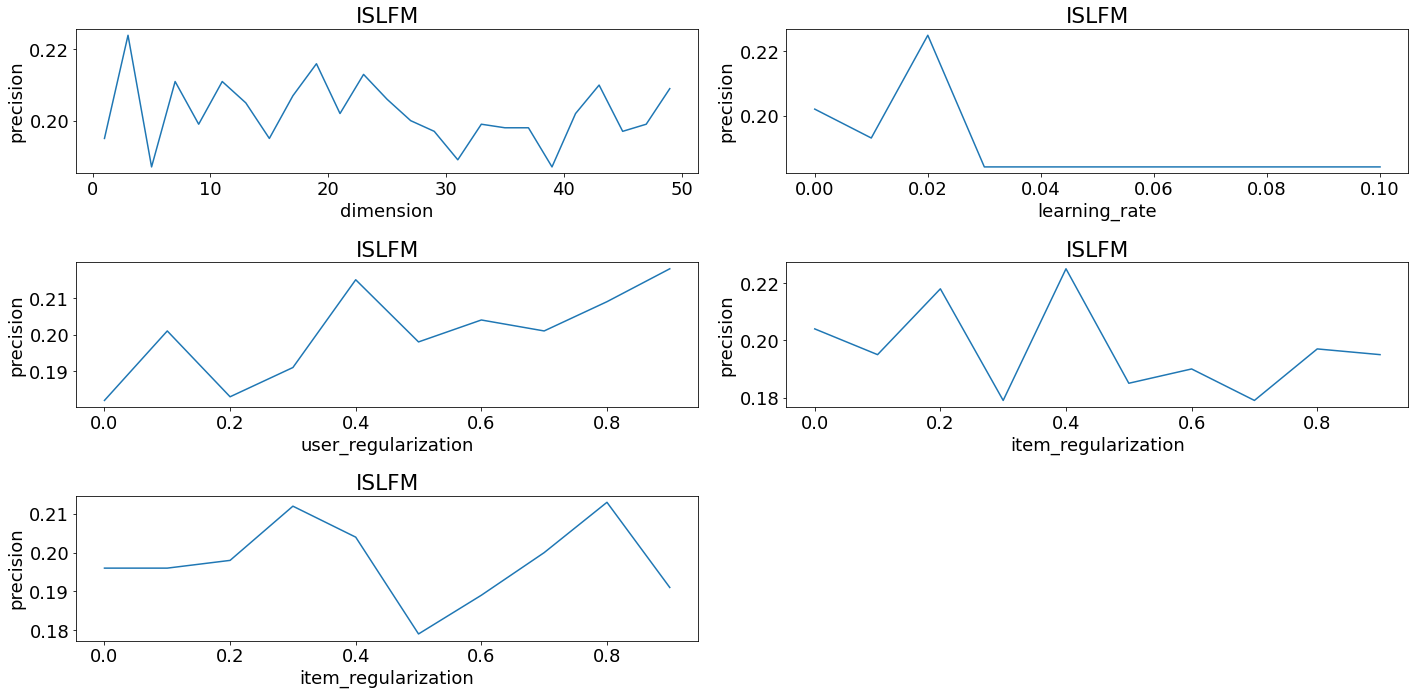

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))

create_plot_2(axes[0, 0], result_metrics_1, PARAMS_DIMENSION_50, 'ISLFM', 'dimension')
create_plot_2(axes[0, 1], result_metrics_2, PARAMS_LEARNING_RATE, 'ISLFM', 'learning_rate')
create_plot_2(axes[1, 0], result_metrics_3, PARAMS_USER_REG, 'ISLFM', 'user_regularization')
create_plot_2(axes[1, 1], result_metrics_4, PARAMS_ITEM_REG, 'ISLFM', 'item_regularization')
create_plot_2(axes[2, 0], result_metrics_5, PARAMS_ITEM_REG, 'ISLFM', 'item_regularization')

axes[-1, -1].axis('off')

fig.tight_layout()

In [26]:
result_metrics_1 = get_metrics_1(
    AlternatingLeastSquaresModel, 'dimension', PARAMS_DIMENSION_50, {}, {'epochs': 30}
)
result_metrics_2 = get_metrics_1(
    HierarchicalAlternatingLeastSquaresModel, 'dimension', PARAMS_DIMENSION_50, {}, {'epochs': 30}
)

100%|██████████| 30/30 [00:01<00:00, 18.06it/s]


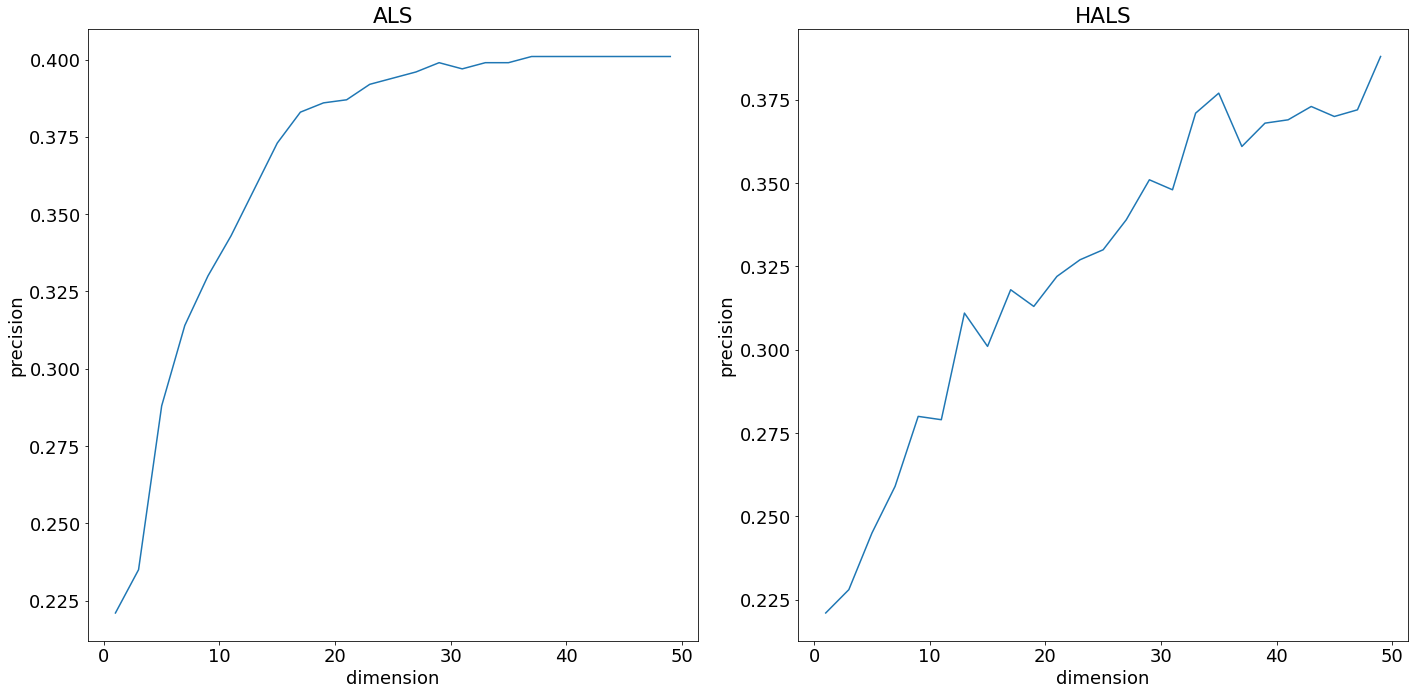

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

create_plot_2(axes[0], result_metrics_1, PARAMS_DIMENSION_50, 'ALS', 'dimension')
create_plot_2(axes[1], result_metrics_2, PARAMS_DIMENSION_50, 'HALS', 'dimension')

fig.tight_layout()

In [28]:
result_metrics_1 = get_metrics_1(
    ImplicitAlternatingLeastSquaresModel, 'dimension', PARAMS_DIMENSION_50, {}, {'epochs': 30}
)
result_metrics_2 = get_metrics_1(
    ImplicitAlternatingLeastSquaresModel, 'influence_regularization', PARAMS_INFLUENCE_REG, 
    {'dimension': 30}, {'epochs': 30}
)
result_metrics_3 = get_metrics_1(
    ImplicitHierarchicalAlternatingLeastSquaresModel, 'dimension', PARAMS_DIMENSION_50, {}, {'epochs': 30}
)
result_metrics_4 = get_metrics_1(
    ImplicitHierarchicalAlternatingLeastSquaresModel, 'influence_regularization', PARAMS_INFLUENCE_REG, 
    {'dimension': 30}, {'epochs': 30}
)

100%|██████████| 30/30 [00:01<00:00, 17.84it/s]


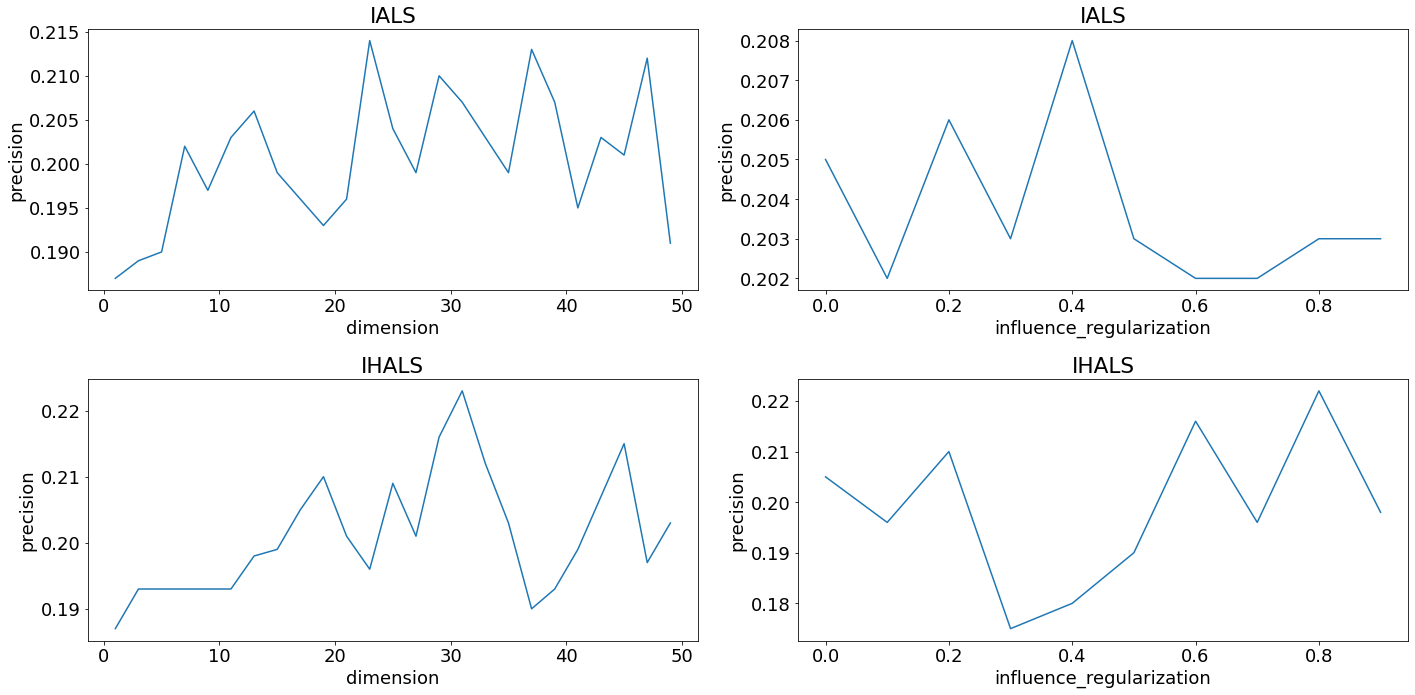

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

create_plot_2(axes[0, 0], result_metrics_1, PARAMS_DIMENSION_50, 'IALS', 'dimension')
create_plot_2(axes[0, 1], result_metrics_2, PARAMS_INFLUENCE_REG, 'IALS', 'influence_regularization')
create_plot_2(axes[1, 0], result_metrics_3, PARAMS_DIMENSION_50, 'IHALS', 'dimension')
create_plot_2(axes[1, 1], result_metrics_4, PARAMS_INFLUENCE_REG, 'IHALS', 'influence_regularization')

fig.tight_layout()

In [30]:
result_metric = get_metrics_1(
    SingularValueDecompositionModel, 'dimension', PARAMS_DIMENSION_50, {}, {}
)

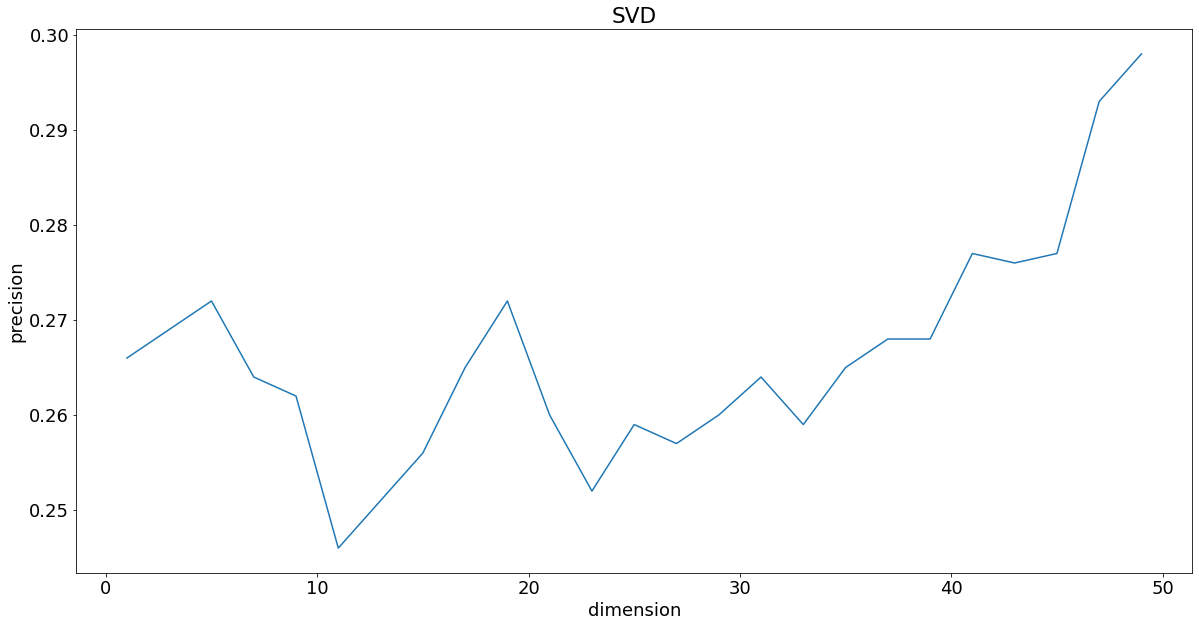

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

create_plot_2(ax, result_metrics, PARAMS_DIMENSION_50, 'SVD', 'dimension')

# Эксперименты с предсказанием рейтингов объектов

In [32]:
def get_indices(data, model, users_count):

    true_indices, predicted_indices = list(), list()

    for user_index in range(users_count):

        predicted_ratings = model.predict_ratings(user_index)
        true_ratings = data.getrow(user_index).toarray()[0]

        barrier_value = true_ratings.mean()
        
        true_indices.append(
            work_with_ratings.calculate_predicted_items(predicted_ratings, barrier_value=barrier_value)
        )
        predicted_indices.append(
            work_with_ratings.calculate_predicted_items(true_ratings, barrier_value=barrier_value)
        )

    return true_indices, predicted_indices

In [33]:
def get_metrics_2(model_class, name_range_parameter, range_parameters, parameters, train_parameters):

    users_count = data.shape[0]

    result_metrics = {
        'precision': list(),
        'recall': list()
    }

    for parameter in range_parameters:
        parameters.update({name_range_parameter: parameter})
        model = model_class(**parameters).fit(x_train.astype(float), **train_parameters)

        true_indices, predicted_indices = get_indices(data, model, users_count)

        result_metrics['precision'].append(precision_k(true_indices, predicted_indices))
        result_metrics['recall'].append(recall_k(true_indices, predicted_indices))

    return result_metrics

In [34]:
def create_plot_3(ax, result_metrics, range_parameters,model_name, parameter_name, metric_name):
    ax.plot(range_parameters, result_metrics[metric_name])
    ax.set_title(model_name)
    ax.set_xlabel(parameter_name)
    ax.set_ylabel(metric_name)

In [35]:
result_metrics = get_metrics_2 (
    UserBasedModel, 'k_nearest_neighbours', PARAMS_KNN_50, {}, {}
)

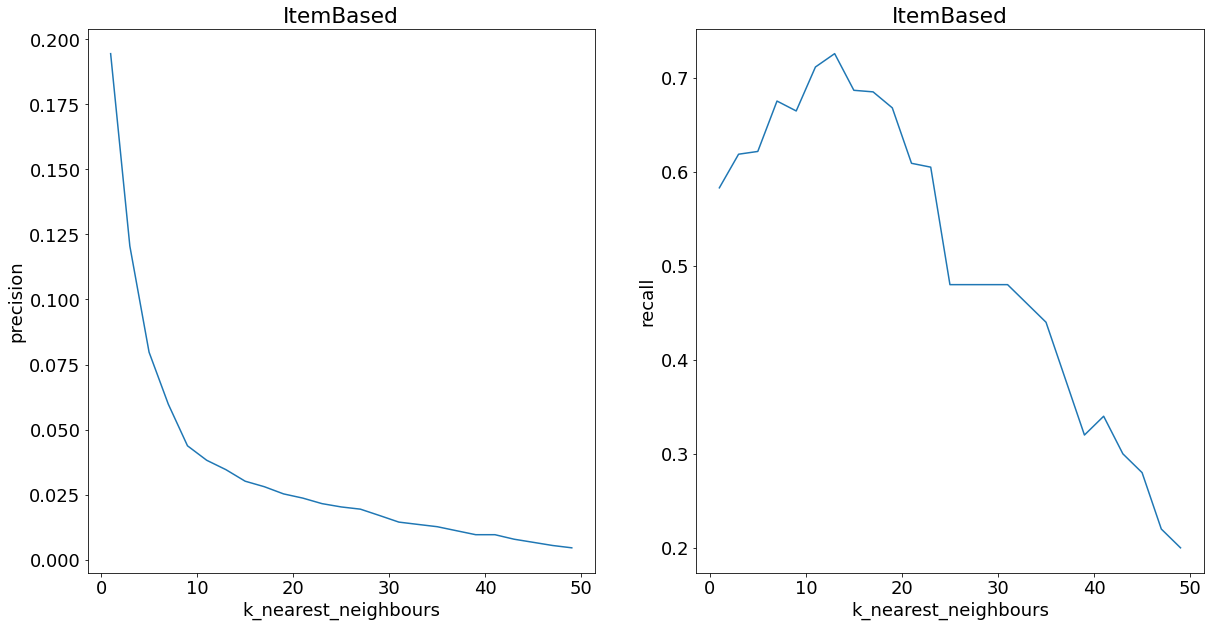

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
create_plot_3(axes[0], result_metrics, PARAMS_KNN_50, 'ItemBased', 'k_nearest_neighbours', 'precision')
create_plot_3(axes[1], result_metrics, PARAMS_KNN_50, 'ItemBased', 'k_nearest_neighbours', 'recall')

In [49]:
result_metrics_1 = get_metrics_2(
    StochasticLatentFactorModel, 'dimension', PARAMS_DIMENSION_50, 
    {'learning_rate': 0.0001}, {'epochs': 30}
)
result_metrics_2 = get_metrics_2(
    StochasticLatentFactorModel, 'learning_rate', PARAMS_LEARNING_RATE, 
    {'dimension': 30}, {'epochs': 30}
)
result_metrics_3 = get_metrics_2(
    StochasticLatentFactorModel, 'user_regularization', PARAMS_USER_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30}
)
result_metrics_4 = get_metrics_2(
    StochasticLatentFactorModel, 'item_regularization', PARAMS_ITEM_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30} 
)

100%|██████████| 30/30 [00:01<00:00, 15.21it/s]


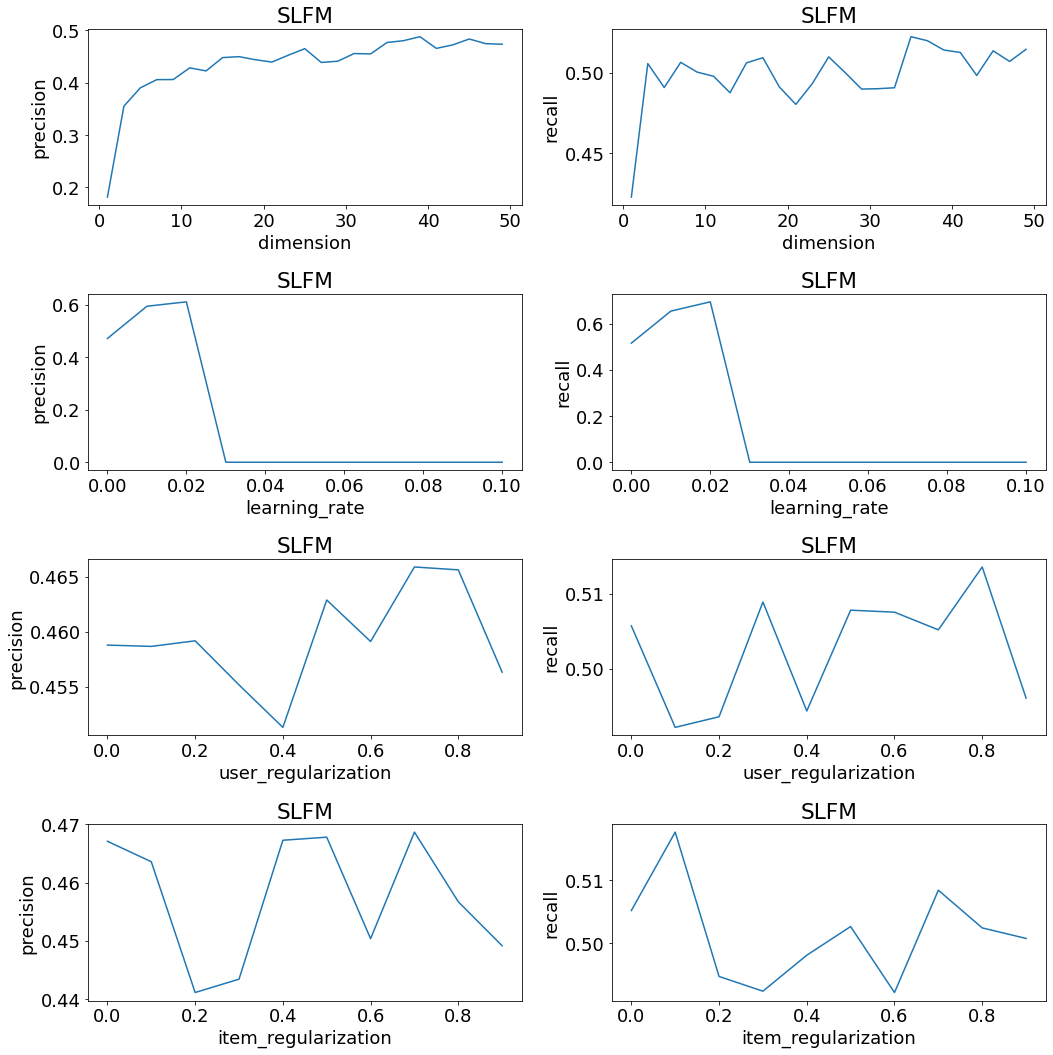

In [50]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

create_plot_3(axes[0, 0], result_metrics_1, PARAMS_DIMENSION_50, 'SLFM', 'dimension', 'precision')
create_plot_3(axes[0, 1], result_metrics_1, PARAMS_DIMENSION_50, 'SLFM', 'dimension', 'recall')
create_plot_3(axes[1, 0], result_metrics_2, PARAMS_LEARNING_RATE, 'SLFM', 'learning_rate', 'precision')
create_plot_3(axes[1, 1], result_metrics_2, PARAMS_LEARNING_RATE, 'SLFM', 'learning_rate', 'recall')
create_plot_3(axes[2, 0], result_metrics_3, PARAMS_USER_REG, 'SLFM', 'user_regularization', 'precision')
create_plot_3(axes[2, 1], result_metrics_3, PARAMS_USER_REG, 'SLFM', 'user_regularization', 'recall')
create_plot_3(axes[3, 0], result_metrics_4, PARAMS_ITEM_REG, 'SLFM', 'item_regularization', 'precision')
create_plot_3(axes[3, 1], result_metrics_4, PARAMS_ITEM_REG, 'SLFM', 'item_regularization', 'recall')

fig.tight_layout()

In [51]:
result_metrics_1 = get_metrics_2(
    ImplicitStochasticLatentFactorModel, 'dimension', PARAMS_DIMENSION_50, 
    {'learning_rate': 0.0001}, {'epochs': 30}
)
result_metrics_2 = get_metrics_2(
    ImplicitStochasticLatentFactorModel, 'learning_rate', PARAMS_LEARNING_RATE, 
    {'dimension': 30}, {'epochs': 30}
)
result_metrics_3 = get_metrics_2(
    ImplicitStochasticLatentFactorModel, 'user_regularization', PARAMS_USER_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30}
)
result_metrics_4 = get_metrics_2(
    ImplicitStochasticLatentFactorModel, 'item_regularization', PARAMS_ITEM_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30} 
)
result_metrics_5 = get_metrics_2(
    ImplicitStochasticLatentFactorModel, 'influence_regularization', PARAMS_INFLUENCE_REG, 
    {'dimension': 30, 'learning_rate': 0.0001}, {'epochs': 30}
)

100%|██████████| 30/30 [00:06<00:00,  4.99it/s]


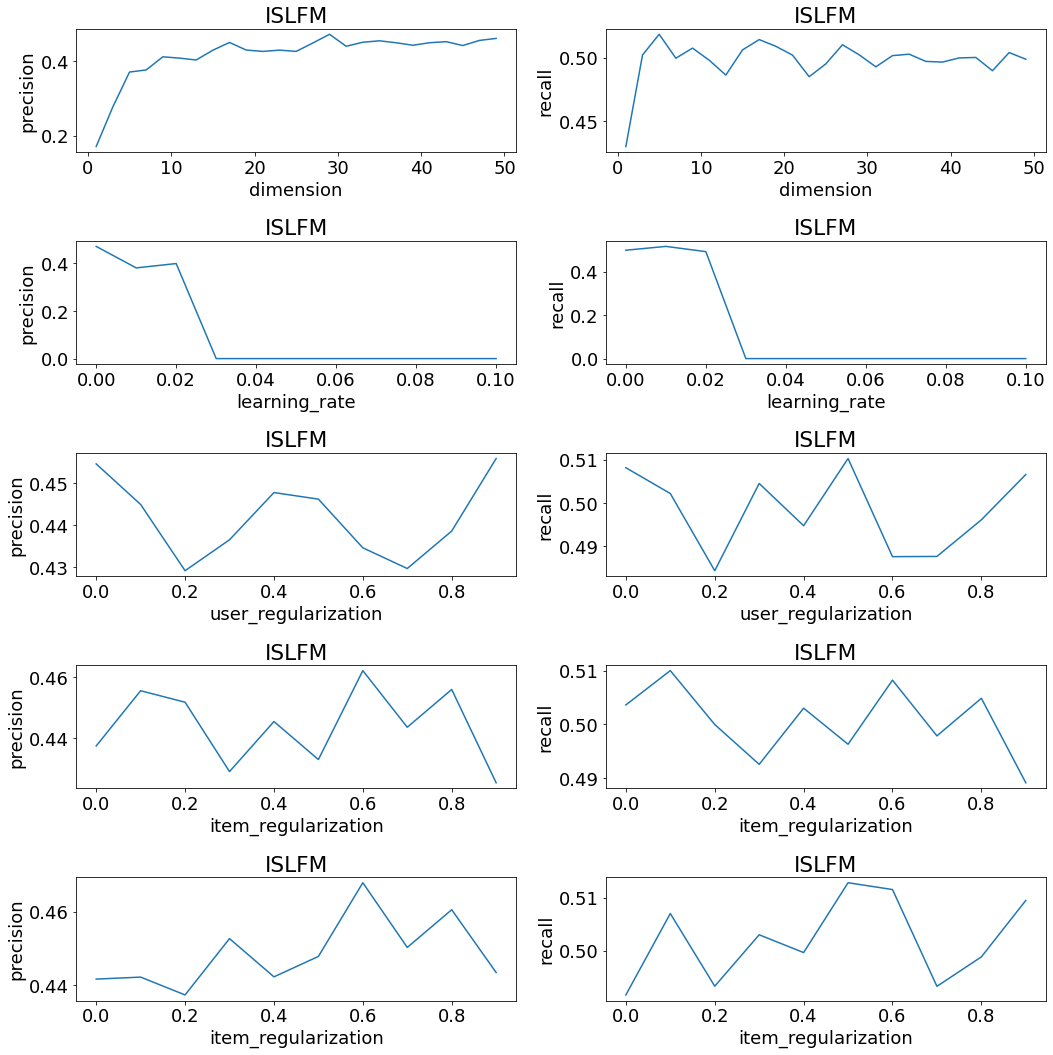

In [52]:
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

create_plot_3(axes[0, 0], result_metrics_1, PARAMS_DIMENSION_50, 'ISLFM', 'dimension', 'precision')
create_plot_3(axes[0, 1], result_metrics_1, PARAMS_DIMENSION_50, 'ISLFM', 'dimension', 'recall')
create_plot_3(axes[1, 0], result_metrics_2, PARAMS_LEARNING_RATE, 'ISLFM', 'learning_rate', 'precision')
create_plot_3(axes[1, 1], result_metrics_2, PARAMS_LEARNING_RATE, 'ISLFM', 'learning_rate', 'recall')
create_plot_3(axes[2, 0], result_metrics_3, PARAMS_USER_REG, 'ISLFM', 'user_regularization', 'precision')
create_plot_3(axes[2, 1], result_metrics_3, PARAMS_USER_REG, 'ISLFM', 'user_regularization', 'recall')
create_plot_3(axes[3, 0], result_metrics_4, PARAMS_ITEM_REG, 'ISLFM', 'item_regularization', 'precision')
create_plot_3(axes[3, 1], result_metrics_4, PARAMS_ITEM_REG, 'ISLFM', 'item_regularization', 'recall')
create_plot_3(axes[4, 0], result_metrics_5, PARAMS_ITEM_REG, 'ISLFM', 'item_regularization', 'precision')
create_plot_3(axes[4, 1], result_metrics_5, PARAMS_ITEM_REG, 'ISLFM', 'item_regularization', 'recall')

fig.tight_layout()

In [53]:
result_metrics_1 = get_metrics_2(
    AlternatingLeastSquaresModel, 'dimension', PARAMS_DIMENSION_50, {}, {'epochs': 30}
)
result_metrics_2 = get_metrics_2(
    HierarchicalAlternatingLeastSquaresModel, 'dimension', PARAMS_DIMENSION_50, {}, {'epochs': 30}
)

100%|██████████| 30/30 [00:01<00:00, 17.94it/s]


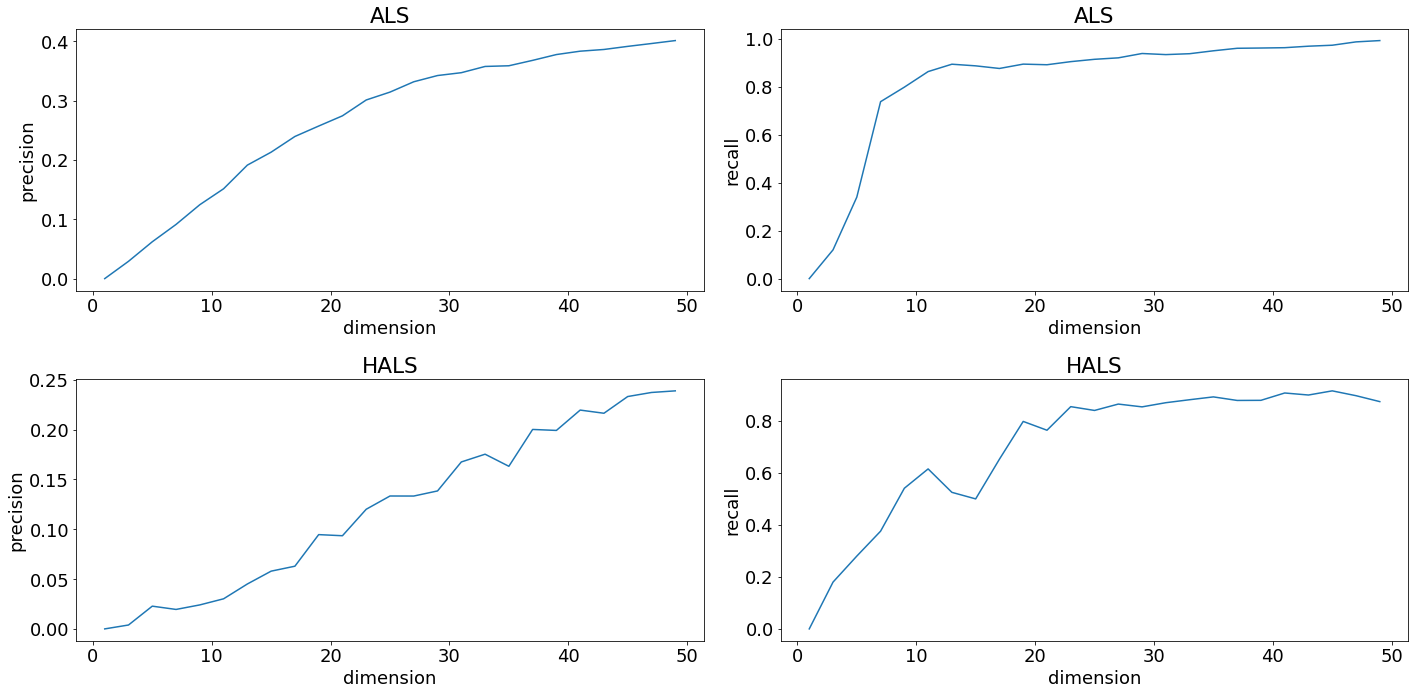

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

create_plot_3(axes[0, 0], result_metrics_1, PARAMS_DIMENSION_50, 'ALS', 'dimension', 'precision')
create_plot_3(axes[0, 1], result_metrics_1, PARAMS_DIMENSION_50, 'ALS', 'dimension', 'recall')
create_plot_3(axes[1, 0], result_metrics_2, PARAMS_DIMENSION_50, 'HALS', 'dimension', 'precision')
create_plot_3(axes[1, 1], result_metrics_2, PARAMS_DIMENSION_50, 'HALS', 'dimension', 'recall')

fig.tight_layout()

In [55]:
result_metrics_1 = get_metrics_2(
    ImplicitAlternatingLeastSquaresModel, 'dimension', PARAMS_DIMENSION_50, {}, {'epochs': 30}
)
result_metrics_2 = get_metrics_2(
    ImplicitAlternatingLeastSquaresModel, 'influence_regularization', PARAMS_INFLUENCE_REG, 
    {'dimension': 30}, {'epochs': 30}
)
result_metrics_3 = get_metrics_2(
    ImplicitHierarchicalAlternatingLeastSquaresModel, 'dimension', PARAMS_DIMENSION_50, {}, {'epochs': 30}
)
result_metrics_4 = get_metrics_2(
    ImplicitHierarchicalAlternatingLeastSquaresModel, 'influence_regularization', PARAMS_INFLUENCE_REG, 
    {'dimension': 30}, {'epochs': 30}
)

100%|██████████| 30/30 [00:01<00:00, 17.04it/s]


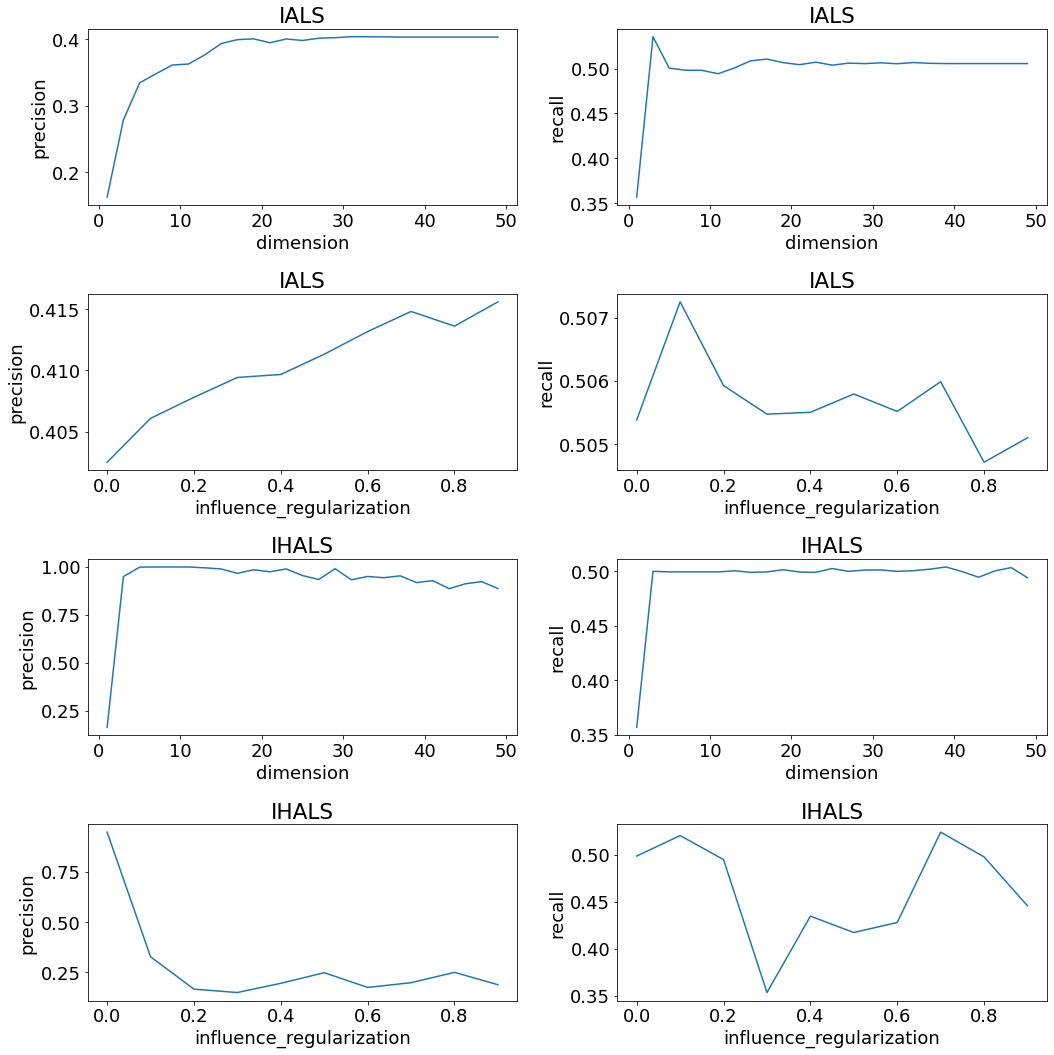

In [56]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

create_plot_3(axes[0, 0], result_metrics_1, PARAMS_DIMENSION_50, 'IALS', 'dimension', 'precision')
create_plot_3(axes[0, 1], result_metrics_1, PARAMS_DIMENSION_50, 'IALS', 'dimension', 'recall')
create_plot_3(axes[1, 0], result_metrics_2, PARAMS_INFLUENCE_REG, 'IALS', 'influence_regularization', 'precision')
create_plot_3(axes[1, 1], result_metrics_2, PARAMS_INFLUENCE_REG, 'IALS', 'influence_regularization', 'recall')
create_plot_3(axes[2, 0], result_metrics_3, PARAMS_DIMENSION_50, 'IHALS', 'dimension', 'precision')
create_plot_3(axes[2, 1], result_metrics_3, PARAMS_DIMENSION_50, 'IHALS', 'dimension', 'recall')
create_plot_3(axes[3, 0], result_metrics_4, PARAMS_INFLUENCE_REG, 'IHALS', 'influence_regularization', 'precision')
create_plot_3(axes[3, 1], result_metrics_4, PARAMS_INFLUENCE_REG, 'IHALS', 'influence_regularization', 'recall')

fig.tight_layout()

In [57]:
result_metric = get_metrics_2(
    SingularValueDecompositionModel, 'dimension', PARAMS_DIMENSION_50, {}, {}
)

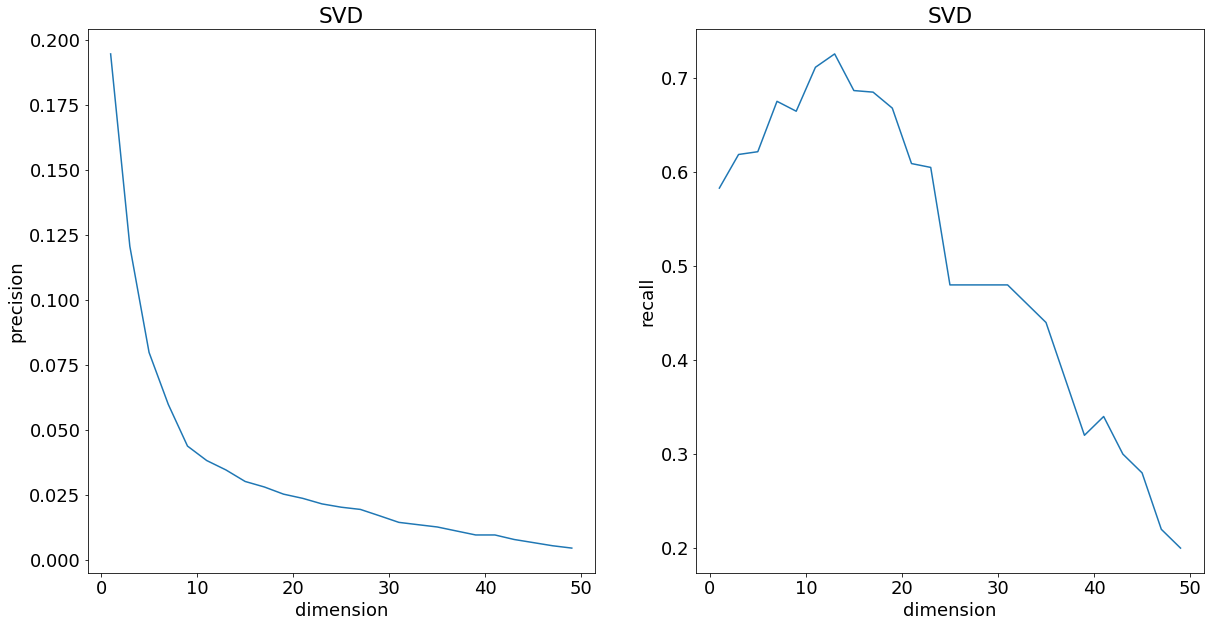

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

create_plot_3(axes[0], result_metrics, PARAMS_DIMENSION_50, 'SVD', 'dimension', 'precision')
create_plot_3(axes[1], result_metrics, PARAMS_DIMENSION_50, 'SVD', 'dimension', 'recall')